## Cornflakes Indentity Operators

First, we need to make a few trivial operators in the cornflakes DSL. We'll be using the tensorflow DSL, but unfortunately there's no easy way to generate the C-structure for kernels in cornflakes. These let us take perform kernel calculations in Tensorflow using pipelining, and then use cornflakes.assemble to build the linear systems.

In [1]:
import popcorn as pc
Vol_2Vec = pc.DofSpace(2,0,1)
Vol_4Vec = pc.DofSpace(4,0,1)
i_R = pc.Input('iR',Vol_2Vec)
i_K = pc.Input('iK',Vol_4Vec)
o_R = pc.Output('R',(Vol_2Vec,),1)
o_K = pc.Output('K',(Vol_2Vec,),2)
pc.Kernel('idty_R',listing=[
    pc.Asgn(o_R,i_R),
])
pc.Kernel('idty_RK',listing=[
    pc.Asgn(o_R,i_R),
    pc.Asgn(o_K,i_K.reshape(2,2)),

])


Vol_2Vec = pc.DofSpace(2,   0,2)
Face_4Vec = pc.DofSpace(4,  2,3)
Face_16Vec = pc.DofSpace(16,2,3)
i_R = pc.Input('iR',Face_4Vec)
i_K = pc.Input('iK',Face_16Vec)
o_R = pc.Output('R',(Vol_2Vec,),1)
o_K = pc.Output('K',(Vol_2Vec,),2)
pc.Kernel('idty_2_R',listing=[
    pc.Asgn(o_R,i_R),
])
pc.Kernel('idty_2_RK',listing=[
    pc.Asgn(o_R,i_R),
    pc.Asgn(o_K,i_K.reshape(4,4))
])

pc.Husk('identity')

# Now the simulator code runs

We first compile and load those identity operators we just wrote above,

In [1]:
import husk_identity

In [2]:
import cornflakes as cf
import numpy as np
import scipy
from matplotlib import pylab as plt

We load up the EOSHub and create a latent sim object from the best network,

In [3]:
from eoshub import EOSHub

{'water_linear': '/Users/afq/Google Drive/networks/', 'water_iapws_rh_lg': '/Users/afq/Documents/Research/LBNL/eoshub/eoshub/networks/', 'water_iapws_lg': '/Users/afq/Google Drive/networks/', 'water_slgc': '/Users/afq/Google Drive/networks/', 'water_iapws_slgc_logp_comp': '/Users/afq/Google Drive/networks/'}


In [4]:
eos = 'water_iapws_slgc_logp_comp'
network = 'Classifying_pT_0.0_2,6,24,48,sigmoid,0.05'
ls = EOSHub.LatentSim(eos,network)

In [5]:
import tensorflow as tf

In [6]:
ls.build_flux()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [7]:
TB,pB,rhoB,rho_hB = tf.split(ls.o_s2,4,axis=-1)
TA,pA,rhoA,rho_hA = tf.split(ls.o_s,4,axis=-1)

In [8]:
L = tf.norm(ls.i_XA-ls.i_XB,axis=-1)
n = tf.einsum('ij,i->ij',(ls.i_XB-ls.i_XA),(1.0/L))

In [9]:
with ls._graph.as_default():
    a = ls.regvar( "k_T", 10.0) * ( tf.einsum('ij,i->ij',(TB - TA),(1.0/L) ) )

In [10]:
a

<tf.Tensor 'mul_15:0' shape=(?, 1) dtype=float64>

Set up the computation graph with cornflakes

In [11]:
Ny = 10
L = 1
X = np.c_[np.zeros((Ny,)),np.linspace(0,Ny,10)]
H_vol = cf.Hypergraph()
for i in range(Ny):
    H_vol.Push_Edge([i])
H_face = cf.Hypergraph()
for i in range(Ny-1):
    H_face.Push_Edge([i,i+1,i+Ny])

Define the cornflakes data and dofmap structures

In [12]:
q = np.zeros(2*Ny)
dm_q = cf.Dofmap(2,0,2)
dm_4 = cf.Dofmap(4,0,4)
dm_face = cf.Dofmap_Strided(4,-4*Ny,4)
dm_face16 = cf.Dofmap_Strided(16,-16*Ny,16)
data = {'q':(q,dm_q),
        'X':(X,dm_q)}

In [13]:
def plot(q):
    s = ls.decode(q.reshape(-1,2))
    for i,leg in enumerate(['T','P','rho','rho*h']):
        plt.subplot(1,4,i+1)
        plt.plot(s[:,i],X)
        plt.xlabel(leg)


In [14]:
ls.set_params(k_p=1.0e-7,k_T=0.1,Dt=1e5)

In [15]:
def build_system(q,q0):
    DT = ls._sess.run(ls._vars['Dt'])
    R0_vol_arr = ls._sess.run([ls.rhs], feed_dict ={ls.i_q:q0.reshape(-1,2)})
    vol_R0, = cf.Assemble(husk_identity.kernel_idty_R,
            H_vol,
            {'iR':(R0_vol_arr,dm_q),},
            {'R':(dm_q,),},ndof=Ny*2)
    # Assemble the mass component:
    K_vol_arr,R_vol_arr = ls._sess.run([ls.K_lhs,ls.lhs], feed_dict ={ls.i_q:q.reshape(-1,2)})
    vol_R,vol_K = cf.Assemble(husk_identity.kernel_idty_RK,
            H_vol,
            {'iR':(R_vol_arr,dm_q),'iK':(K_vol_arr,dm_4)},
            {'R':(dm_q,),'K':(dm_q,)},ndof=Ny*2)
    # Assemble the fluxes:
    q_face = np.array([ q[dm_q.Get_List(e[0:2])] for e in H_face ])
    X_face =np.array([ X.ravel()[dm_q.Get_List(e[0:2])] for e in H_face ])
    qA = q_face[:,0:2]
    qB = q_face[:,2:4]
    XA = X_face[:,0:2]
    XB = X_face[:,2:4]
    oF,oKF = ls._sess.run([ls.o_F,ls.o_KF],feed_dict={
        ls.i_q:qA,ls.i_q2:qB,
        ls.i_XA:XA,ls.i_XB:XB})
    flux_R,flux_K=cf.Assemble(husk_identity.kernel_idty_2_RK,
            H_face,
            {'iR':(oF.flatten(),dm_face),'iK':(oKF.flatten(),dm_face16)},
            {'R':(dm_q,),'K':(dm_q,)},ndof=Ny*2)
    #print(flux_R)
    # Make the runge kutta system
    RR = vol_R0 - vol_R + DT*flux_R
    KK = vol_K - DT*flux_K
    return RR,KK

In [16]:
rho0,T0 = 700,300
q0 = ls.find_point(rho=rho0,T=T0)
for e in H_vol:
    q[dm_q.Get_List(e)] = q0
q0 = q.copy()

In [17]:
q[:] = q0

In [18]:
plt.close('all')

0.13038627567141695
0.021022596353572044
0.0005922226240617614
1.6475198498461105e-06
9.55667480234118e-12
0.1066496481243684
0.03712062332244977
0.010429030828543746
0.0013527226389205677
2.0703214975082493e-05
0.06061160339579186
0.004011125955324271
0.00012179922276751783
5.237696168167317e-08
1.2449614019745157e-14
0.06105827562697495
0.005670666996531167
0.0002667029280029487
2.87588186122913e-07
5.644860026984127e-13
0.06694214809617205
0.0023787037274306134
8.08741250704348e-06
8.485800216698467e-11
9.274134670066976e-16
0.0753300705933087
0.0023007109692801545
2.0842947698394947e-05
1.6677012194176043e-09
9.62595851805997e-16
0.08568580673165437
0.002418970458264956
2.3634725448091292e-05
2.3335195334954918e-09
3.9149894217002697e-16
0.09547904521764494
0.003228766542469324
1.788564488752392e-05
8.419920328796954e-10
1.480867329676685e-15
0.09901277295010416
0.003681475146625607
3.666087219848709e-05
5.622308632167504e-09
9.606256089079236e-16
0.09829126071106453
0.008070835144

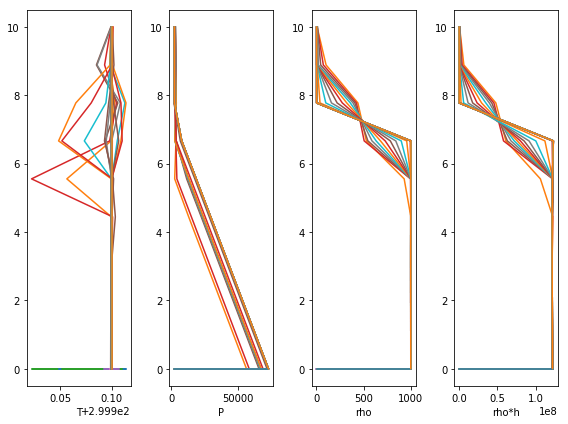

In [22]:
plt.figure(figsize=(8,6))
plot(q)
for t in range(25):
    for i in range(5):
        R,K = build_system(q,q0)
        Dq = scipy.sparse.linalg.spsolve(K,R)
        q[:] += Dq
        print(np.linalg.norm(Dq))
    q0[:]=q[:]
    plot(q)
plt.tight_layout()
plt.show()

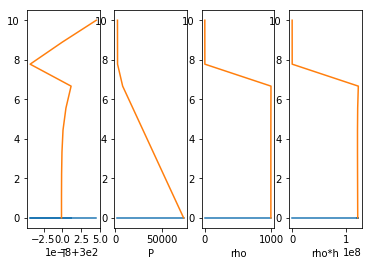

In [23]:
plot(q)

# scratch

In [19]:
X = cf.ParticlePlacers.init_grid(Nx=5,Ny=5,start=[0,0],e1=[L,0],e2=[0,L])
H = cf.Graphers.Build_Pair_Graph(X,cutoff=0.12)

In [21]:
H.view()

[array([[ 0,  2],
        [ 1,  3],
        [ 2,  4],
        [ 3,  5],
        [ 4,  6],
        [ 5,  7],
        [ 6,  8],
        [ 7,  9],
        [ 8, 10],
        [ 9, 11],
        [10, 12],
        [11, 13],
        [14, 12],
        [14, 16],
        [15, 13],
        [15, 17],
        [16, 18],
        [17, 19]], dtype=int32)]

In [29]:
for e in H:
    plt.plot(X[:,e[0]],X[:,e[1]])
plt.show()

IndexError: too many indices for array